In [1]:
from shearnet.core.dataset import generate_dataset, split_combined_images

from shearnet.deconvnet.methods.galsim_deconv import deconvolve_single, deconvolve

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import Optional

In [2]:
def plot_comparison(target_images, convolved_images, galsim_deconv_preds, num_samples=5, save_path=None):
    """Create a simple comparison plot showing truth, neural, and galsim.deconv results."""
    
    # Ensure all images have the same shape
    if target_images.ndim == 4:
        target_images = target_images.squeeze(-1)
    if convolved_images.ndim == 4:
        convolved_images = convolved_images.squeeze(-1)
    if galsim_deconv_preds.ndim == 4:
        galsim_deconv_preds = galsim_deconv_preds.squeeze(-1)
    
    fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))
    
    for i in range(num_samples):
        # Truth
        axes[0, i].imshow(target_images[i], cmap='viridis')
        axes[0, i].set_title(f'Truth {i+1}')
        axes[0, i].axis('off')
        
        # Neural
        axes[1, i].imshow(convolved_images[i], cmap='viridis')
        axes[1, i].set_title(f'Convolved {i+1}')
        axes[1, i].axis('off')
        
        # Galsim.deconv
        axes[2, i].imshow(galsim_deconv_preds[i], cmap='viridis')
        axes[2, i].set_title(f'Galsim.deconv {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to: {save_path}")
    else:
        plt.show()
    
    plt.close()

# def plot_spatial_residuals(target_images: jnp.ndarray, 
#                                  galsim_deconv_predictions: jnp.ndarray, path: Optional[str] = None,
#                                  title: str = "Spatial Deconvolution Residuals"):
#     """
#     Plot spatial residual heat maps showing systematic biases across image coordinates.
    
#     This shows WHERE in the galaxy each deconvolution method systematically fails,
#     averaged across all test images. Zero = perfect deconvolution at that pixel.
    
#     Args:
#         target_images: Ground truth clean images [N, H, W] or [N, H, W, 1]
#         galsim_deconv_predictions: Galsim deconvolution results [N, H, W] or [N, H, W, 1]
#         path: Path to save the plot
#         title: Plot title
#     """
    
#     # Ensure consistent shapes - squeeze out channel dimensions
#     if target_images.ndim == 4:
#         target_images = target_images.squeeze(-1)
#     if galsim_deconv_predictions.ndim == 4:
#         galsim_deconv_predictions = galsim_deconv_predictions.squeeze(-1)
    
#     # Calculate mean residuals across all images at each pixel coordinate
#     # This gives systematic bias: positive = over-deconvolution, negative = under-deconvolution
#     galsim_deconv_spatial_bias = jnp.mean(galsim_deconv_predictions - target_images, axis=0)

#     # Calculate standard deviation of residuals at each pixel
#     galsim_deconv_residual_std = jnp.std(galsim_deconv_predictions - target_images, axis=0)
    
#     # Find the maximum absolute value across all bias maps for consistent scaling
#     global_vmax = jnp.max(jnp.array([
#         jnp.max(jnp.abs(galsim_deconv_spatial_bias)),
#     ]))
    
#     # Find the maximum value across std maps for consistent scaling
#     global_std_vmax = jnp.max(jnp.array([
#         jnp.max(galsim_deconv_residual_std)
#     ]))
    
#     # Set up the plot with 2 rows, 1 columns
#     fig, axes = plt.subplots(2, 1, figsize=(18, 12))
#     # Flatten axes for easier indexing
#     axes = axes.flatten()
    
#     # Galsim.deconv spatial bias  
#     im2 = axes[0].imshow(galsim_deconv_spatial_bias, cmap='RdBu_r', origin='lower',
#                            vmin=-global_vmax, vmax=global_vmax)
#     axes[0].set_title('Galsim.deconv\nSpatial Bias Map')
#     axes[0].axis('off')
#     plt.colorbar(im2, ax=axes[0], fraction=0.046, pad=0.04, label='Mean Residual')
    
#     # Galsim.deconv standard deviation
#     im5 = axes[1].imshow(galsim_deconv_residual_std, cmap='viridis', origin='lower',
#                            vmin=0, vmax=global_std_vmax)
#     axes[1].set_title('Galsim.deconv Residual\nStandard Deviation')
#     axes[1].axis('off')
#     plt.colorbar(im5, ax=axes[1], fraction=0.046, pad=0.04, label='Residual Std')
    
#     plt.suptitle(title, fontsize=16, weight='bold')
#     plt.tight_layout()
    
#     if path:
#         os.makedirs(os.path.dirname(path), exist_ok=True)
#         plt.savefig(path, dpi=300, bbox_inches='tight')
#         print(f"Spatial residuals plot saved to: {path}")
#     else:
#         plt.show()
    
#     plt.close()

In [3]:
"""
GENERATE JUST A TWO SAMPLES :)
"""

combined_images, __, obs = generate_dataset(
    2, 0.25, exp='superbit', seed=42, npix=53, 
    scale=0.141, nse_sd=1e-2, return_clean=True, return_obs=True
)

# Split into galaxy, psf, and clean (target) images
test_galaxy_images, test_target_images = split_combined_images(combined_images, has_psf=False, has_clean=True)


100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


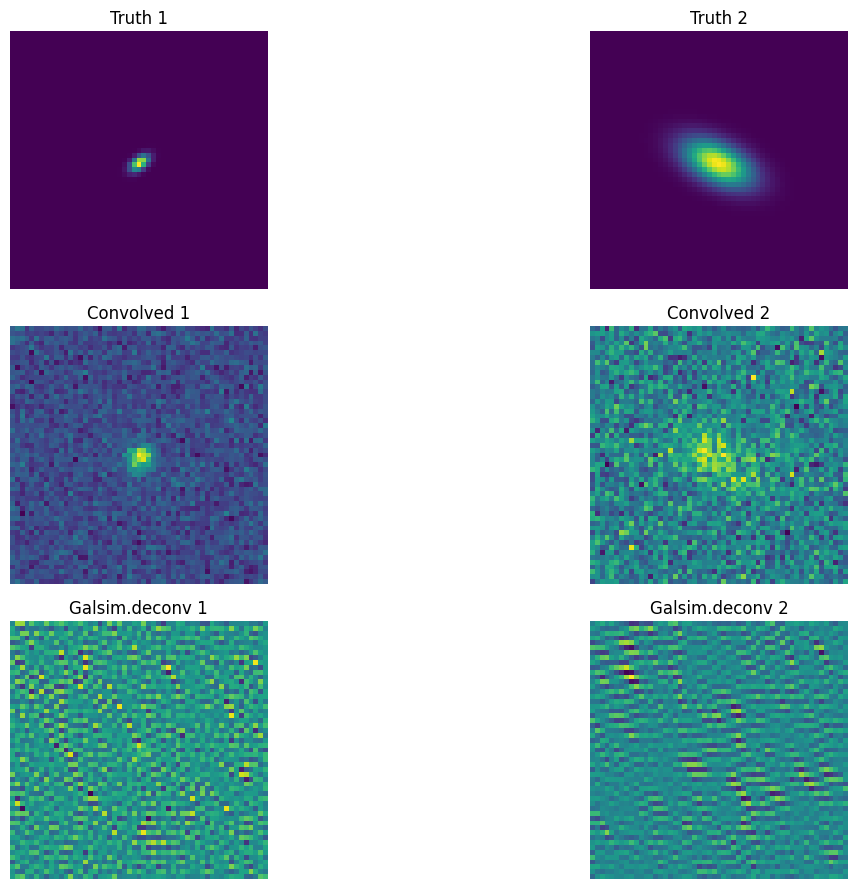

In [4]:
"""
Deconvolve with Galsim
And show results
"""

deconvolved_images = deconvolve(obs)

plot_comparison(test_target_images, test_galaxy_images, deconvolved_images, num_samples=2)

100%|██████████| 100/100 [00:01<00:00, 58.35it/s]



=== GalSim Deconvolution (Using Pre-existing Obs) ===
Evaluation Time: 1.43 seconds
Mean Squared Error (MSE): 9.321185e-01
Mean Absolute Error (MAE): 5.404925e-01
Peak Signal-to-Noise Ratio (PSNR): -17.27 dB
Bias: -4.982920e-04
Computing spatial residuals for 100 images across 1 methods...


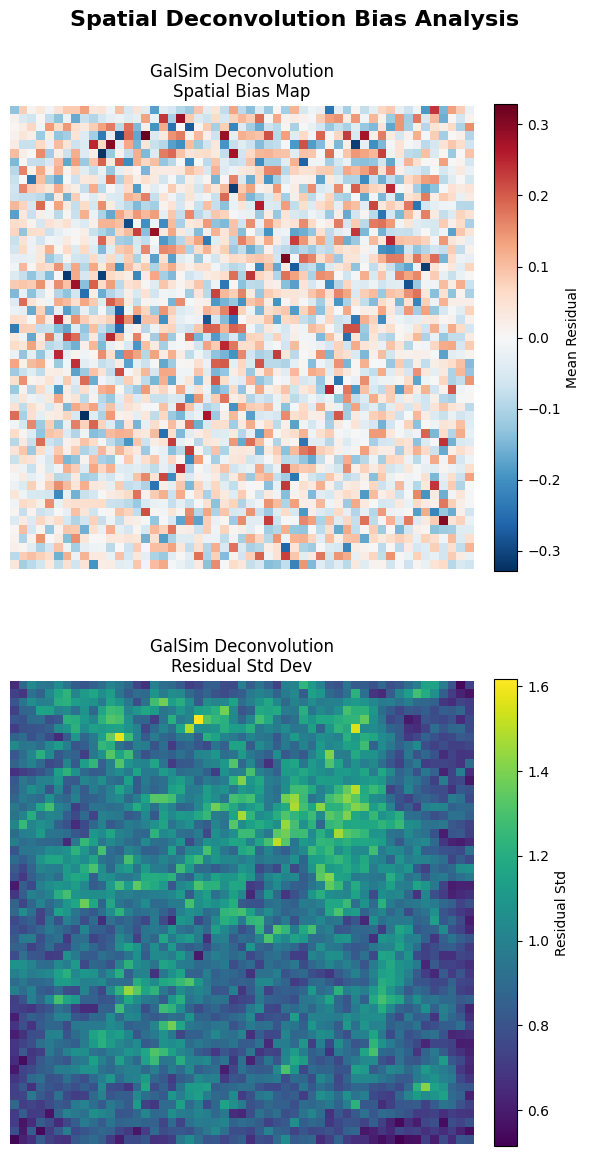

In [9]:
"""
Run analysis of performance
"""

test_target_images, __, obs = generate_dataset(
    100, 0.25, exp='superbit', seed=42, npix=53, 
    scale=0.141, nse_sd=1e-2, return_obs=True, 
)

#deconvolved_images = deconvolve(obs)

from shearnet.deconvnet.utils.metrics import eval_galsim_deconv, normalize_data,inverse_normalized_data

#(test_target_images, __, __), (means, stds) = normalize_data(test_target_images, test_target_images, test_target_images)

galsim_results = eval_galsim_deconv(
    observations=obs,
    target_images=test_target_images
)

#(predictions, __, __) = inverse_normalized_data(galsim_results['predictions'], galsim_results['predictions'], galsim_results['predictions'], means, stds)

predictions_dict = {
    'GalSim Deconvolution': galsim_results['predictions']
}

from shearnet.deconvnet.utils.plot_helpers import plot_spatial_residuals

plot_spatial_residuals(
    target_images=test_target_images,
    predictions_dict=predictions_dict,
    path=None,
    title="Spatial Deconvolution Bias Analysis"
)